In [86]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

- [Simulator Class](#Simulator-Class)
- [Simulator Model](#Simulator-Model)
- [Exception](#Exception)
- [Markov Jump Process](#MJP)
- [Lotka-Volterra Markov Jump Process](#LV-MJP)
- [Lotka-Volterra Model](#LV-Model)
- [Lotka-Volterra Sufficient Statistics](#Sufficient-Statistics)
- [Simulate Data](#Simulate-Data)
- [Ground Truth Obs](#Ground-Truth-Obs)
- [LVSimulator](#LVSimulator)
- [Test](#Test)
- [Run](#Run)

# Simulator Class

In [65]:
class Simulator:
    """
    Base class for all simulator models.
    """

    def __init__(self):
        self.num_total_simulations = 0

    def simulate(self, parameters):
        """
        Core method which returns a torch.Tensor batch of observations given a
        torch.Tensor batch of parameters.
        :param parameters: torch.Tensor batch of parameters.
        :return: torch.Tensor batch of observations.
        """
        raise NotImplementedError

    @staticmethod
    def get_ground_truth_parameters():
        """
        Returns ground truth parameters which generated the observed data x0.
        :return: torch.Tensor true parameters.
        """
        raise NotImplementedError

    @staticmethod
    def get_ground_truth_observation():
        """
        Returns observation x0 generated by ground truth parameters.
        :return: torch.Tensor true observation.
        """
        raise NotImplementedError

    def get_ground_truth(self):
        """
        Returns ground truth (parameter, observation) pair.
        :return: tuple (ground_truth_parameters, ground_truth_observation)
        """
        return self.get_ground_truth_parameters(), self.get_ground_truth_observation()

    @property
    def parameter_dim(self):
        """
        Dimension of parameters for simulator.
        :return: int parameter_dim
        """
        raise NotImplementedError

    @property
    def observation_dim(self):
        """
        Dimension of observations for simulator.
        TODO: decide whether observation_dim always corresponds to dimension of summary.
        :return: int observation_dim
        """
        raise NotImplementedError

    @property
    def name(self):
        """
        Name of the simulator.
        :return: str name
        """
        raise NotImplementedError

    @property
    def parameter_plotting_limits(self):
        """
        Plotting limits for simulator parameters.
        :return:
        """
        raise NotImplementedError


# Simulator Model

In [66]:
class SimulatorModel:
    """
    Base class for a simulator model.
    """

    def __init__(self):

        self.n_sims = 0

    def sim(self, ps):

        raise NotImplementedError("simulator model must be implemented as a subclass")

# Exception

In [67]:
class SimTooLongException(Exception):
    """
    Exception to be thrown when a simulation runs for too long.
    """

    def __init__(self, max_n_steps):
        self.max_n_steps = max_n_steps

    def __str__(self):
        return "Simulation exceeded the maximum of {} steps.".format(self.max_n_steps)


# MJP

In [68]:
class MarkovJumpProcess:

    def __init__(self, init, params):
        self.state = None
        self.params = None
        self.time = None
        self.reset(init, params)

    def reset(self, init, params):
        self.state = np.asarray(init, dtype=float)
        self.params = np.asarray(params, dtype=float)
        self.time = 0.0

    def _calc_propensities(self):
        raise NotImplementedError(
            "This is an abstract method and should be implemented in a subclass."
        )

    def _do_reaction(self, reaction):
        raise NotImplementedError(
            "This is an abstract method and should be implemented in a subclass."
        )

    def sim_steps(self, num_steps, include_init_state=True, rng=np.random):

        times = [self.time]
        states = [self.state.copy()]

        for _ in range(num_steps):

            rates = self.params * self._calc_propensities()
            total_rate = rates.sum()

            if total_rate == 0:
                self.time = float("inf")
                break

            self.time += rng.exponential(scale=1.0 / total_rate)

            reaction = discrete_sample(rates / total_rate, rng=rng)
            self._do_reaction(reaction)

            times.append(self.time)
            states.append(self.state.copy())

        if not include_init_state:
            times, states = times[1:], states[1:]

        return np.array(times), np.array(states)

    def sim_time(
        self,
        dt,
        duration,
        include_init_state=True,
        max_n_steps=float("inf"),
        rng=np.random,
    ):

        num_rec = int(duration / dt) + 1
        states = np.empty([num_rec, self.state.size], float)
        cur_time = self.time
        n_steps = 0

        for i in range(num_rec):

            while cur_time > self.time:

                rates = self.params * self._calc_propensities()
                total_rate = rates.sum()

                if total_rate == 0:
                    self.time = float("inf")
                    break

                self.time += rng.exponential(scale=1.0 / total_rate)

                reaction = discrete_sample(rates / total_rate, rng=rng)
                self._do_reaction(reaction)

                n_steps += 1
                if n_steps > max_n_steps:
                    raise SimTooLongException(max_n_steps)

            states[i] = self.state.copy()
            cur_time += dt

        return states if include_init_state else states[1:]


# LV MJP

In [69]:
class LotkaVolterra(MarkovJumpProcess):
    """
    The Lotka-Volterra implementation of the Markov Jump Process.
    """

    def _calc_propensities(self):

        x, y = self.state
        xy = x * y
        return np.array([xy, x, y, xy])

    def _do_reaction(self, reaction):

        if reaction == 0:
            self.state[0] += 1

        elif reaction == 1:
            self.state[0] -= 1

        elif reaction == 2:
            self.state[1] += 1

        elif reaction == 3:
            self.state[1] -= 1

        else:
            raise ValueError("Unknown reaction.")

# LV Model

In [70]:
class Model(SimulatorModel):
    """
    The Lotka-Volterra model.
    """

    def __init__(self):

        SimulatorModel.__init__(self)

        self.init = [50, 100]
        self.dt = 0.2
        self.duration = 30
        self.max_n_steps = 10000
        self.lv = LotkaVolterra(self.init, None)

    def sim(self, ps, remove_failed=False, rng=np.random):
        """ps = paramets (log?)"""

        # ps = utils.tensor2numpy(ps)

        ps = np.asarray(ps, float)
        ps = np.exp(ps)

        if ps.ndim == 1:

            self.n_sims += 1

            try:
                self.lv.reset(self.init, ps)
                states = self.lv.sim_time(
                    self.dt, self.duration, max_n_steps=self.max_n_steps, rng=rng
                )
                return states.flatten()

            except SimTooLongException:
                return None

        elif ps.ndim == 2:

            data = []

            for i, p in enumerate(ps):

                try:
                    self.lv.reset(self.init, p)
                    states = self.lv.sim_time(
                        self.dt, self.duration, max_n_steps=self.max_n_steps, rng=rng
                    )
                    data.append(states.flatten())

                except SimTooLongException:
                    data.append(None)

            if remove_failed:
                data = filter(lambda u: u is not None, data)

            self.n_sims += ps.shape[0]

            return np.array(data)

        else:
            raise ValueError("wrong size")

# Sufficient Statistics

In [71]:
class Stats:
    """
    Summary statistics for the Lotka-Volterra model.
    """

    def __init__(self):

        path = os.path.join(
            get_data_root(), "lotka-volterra", "pilot_run_results.pkl"
        )
        with open(path, "rb") as file:
            self.means, self.stds = pickle.load(file, encoding="bytes")

    def calc(self, data):

        if data is None:
            return None

        data = np.asarray(data)
        has_nones = np.any(map(lambda u: u is None, data))

        if data.ndim == 1 and not has_nones:
            return self._calc_one_datapoint(data)

        else:
            return np.array(
                [None if x is None else self._calc_one_datapoint(x) for x in data]
            )

    def _calc_one_datapoint(self, data):

        xy = np.reshape(data, [-1, 2])
        x, y = xy[:, 0], xy[:, 1]
        N = xy.shape[0]

        # means
        mx = np.mean(x)
        my = np.mean(y)

        # variances
        s2x = np.var(x, ddof=1)
        s2y = np.var(y, ddof=1)

        # standardize
        x = (x - mx) / np.sqrt(s2x)
        y = (y - my) / np.sqrt(s2y)

        # auto correlation coefficient
        acx = []
        acy = []
        for lag in [1, 2]:
            acx.append(np.dot(x[:-lag], x[lag:]) / (N - 1))
            acy.append(np.dot(y[:-lag], y[lag:]) / (N - 1))

        # cross correlation coefficient
        ccxy = np.dot(x, y) / (N - 1)

        # normalize stats
        xs = np.array(
            [mx, my, np.log(s2x + 1.0), np.log(s2y + 1.0)] + acx + acy + [ccxy]
        )
        xs -= self.means
        xs /= self.stds

        return xs

# Simulate Data

In [72]:
def sim_data(gen_params, sim_model, n_samples=None, rng=np.random):
    """
    Simulates a and returns a given number of samples from the simulator.
    Takes care of failed simulations, and guarantees the exact number of requested samples will be returned.
    If number of samples is None, it returns one sample.
    """

    if n_samples is None:
        ps, xs = sim_data(gen_params, sim_model, n_samples=1, rng=rng)
        return ps[0], xs[0]

    assert n_samples > 0

    ps = None
    xs = None

    while True:

        # simulate parameters and data
        ps = gen_params(n_samples, rng=rng)
        xs = sim_model(ps, rng=rng)

        # filter out simulations that failed
        idx = [x is not None for x in xs]

        if not np.any(idx):
            continue

        if not np.all(idx):
            ps = np.stack(ps[idx])
            xs = np.stack(xs[idx])

        break  # we'll break only when we have at least one successful simulation

    n_rem = n_samples - ps.shape[0]
    assert n_rem < n_samples

    if n_rem > 0:
        # request remaining simulations
        ps_rem, xs_rem = sim_data(gen_params, sim_model, n_rem, rng)
        ps = np.concatenate([ps, ps_rem], axis=0)
        xs = np.concatenate([xs, xs_rem], axis=0)

    assert ps.shape[0] == xs.shape[0] == n_samples

    return ps, xs


# Ground Truth Obs


In [73]:
def get_ground_truth_observation():
    path = os.path.join(get_data_root(), "lotka-volterra", "obs_stats.pkl")
    with open(path, "rb") as file:
        true_observation = pickle.load(file, encoding="bytes")
    return np.array(true_observation)

# LVSimulator

In [74]:
class LotkaVolterraSimulator(Simulator):
    """
    Implementation of Lotka-Volterra stochastic predator-prey dynamics using a Markov Jump
    Process simulated using the Gillespie algorithm.
    Code follows setup in
    'Fast epsilon-free Inference of Simulation Models with Bayesian Conditional
    Density Estimation'
    Papmakarios & Murray
    NeurIPS 2016
    https://arxiv.org/abs/1605.06376
    """

    def __init__(self, summarize_observations=True, gaussian_prior=False):

        super().__init__()

        super().__init__()
        self._simulator = Model()
        self._summarizer = Stats()
        self._has_been_used = False
        self._gaussian_prior = gaussian_prior

    def simulate(self, parameters):
        parameters = tensor2numpy(parameters)
        observations = self._summarizer.calc(self._simulator.sim(parameters))
        return observations

    def get_ground_truth_parameters(self):
        """
        Ground truth parameters as given in
        'Fast epsilon-free Inference of Simulation Models with Bayesian Conditional
        Density Estimation'
        :return:
        """
        return torch.log(torch.Tensor([0.01, 0.5, 1.0, 0.01]))

    def get_ground_truth_observation(self):
        path = os.path.join(get_data_root(), "lotka-volterra", "obs_stats.pkl")
        with open(path, "rb") as file:
            true_observation = pickle.load(file, encoding="bytes")
        return torch.Tensor(true_observation)

    @property
    def parameter_dim(self):
        return 4

    @property
    def observation_dim(self):
        if self._summarize_observations:
            return 9
        else:
            return 32

    @property
    def parameter_plotting_limits(self):
        return [-5, 2]

    @property
    def name(self):
        return "lotka-volterra"

    @property
    def normalization_parameters(self):
        mean = -1.5 * torch.ones(4)
        std = ((49 / 12) ** 0.5) * torch.ones(4)
        return mean, std

    def _get_prior_parameters_observations(self):
        """
        Lotka-Volterra simulator is expensive, so load prior simulations from disk.
        :return: np.array, np.array
        """
        self._has_been_used = True

        file = (
            "prior-parameters.npy"
            if not self._gaussian_prior
            else "prior-parameters-gaussian.npy"
        )
        parameters = np.load(
            os.path.join(get_data_root(), "lotka-volterra", file)
        )

        file = (
            "prior-observations.npy"
            if not self._gaussian_prior
            else "prior-observations-gaussian.npy"
        )
        observations = np.load(
            os.path.join(get_data_root(), "lotka-volterra", file)
        )

        ix = np.random.permutation(range(parameters.shape[0]))

        return parameters[ix], observations[ix]



# Test

In [75]:
def test_():

    num_simulations = 250
    true_parameters = np.log([0.01, 0.5, 1.0, 0.01])

    parameters, observations = sim_data(
        gen_params=lambda num_simulations, rng: np.tile(
            true_parameters, num_simulations
        ).reshape(-1, 4),
        sim_model=lambda parameters, rng: Stats().calc(
            Model().sim(parameters, rng=rng)
        ),
        n_samples=num_simulations,
    )
    print(parameters.shape, observations.shape)
    # utils.plot_hist_marginals(parameters, ground_truth=np.log([0.01, 0.5, 1.0, 0.01]))
    plot_hist_marginals(
        observations, show_xticks=True, ground_truth=get_ground_truth_observation()
    )
    plt.show()

In [91]:
true_parameters

array([-4.60517019, -0.69314718,  0.        , -4.60517019])

In [95]:
np.tile(true_parameters, 250).reshape(-1, 4)

array([[-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.69314718,  0.        , -4.60517019],
       [-4.60517019, -0.

# Run

In [76]:
def get_data_root():
    if ON_CLUSTER:
        return os.path.join(get_project_root(), "data")
    else:
        return os.path.join(get_project_root(), "data")

def tensor2numpy(x):
    return x.detach().cpu().numpy()

In [77]:
def plot_hist_marginals(
    data,
    weights=None,
    lims=None,
    ground_truth=None,
    upper=True,
    rasterized=True,
    show_xticks=False,
):
    """
    Plots marginal histograms and pairwise scatter plots of a dataset.
    """

    data = np.asarray(data)
    n_bins = int(np.sqrt(data.shape[0]))
    n_bins = 25

    if data.ndim == 1:

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.hist(data, weights=weights, bins=n_bins, density=True, rasterized=rasterized)
        ax.set_ylim([0.0, ax.get_ylim()[1]])
        ax.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
        if lims is not None:
            ax.set_xlim(lims)
        if ground_truth is not None:
            ax.vlines(ground_truth, 0, ax.get_ylim()[1], color="r")

    else:

        n_dim = data.shape[1]
        fig = plt.figure(figsize=(8, 8))

        if weights is None:
            col = "k"
            vmin, vmax = None, None
        else:
            col = weights
            vmin, vmax = 0.0, np.max(weights)

        if lims is not None:
            lims = np.asarray(lims)
            lims = np.tile(lims, [n_dim, 1]) if lims.ndim == 1 else lims

        for i in range(n_dim):
            for j in range(i, n_dim) if upper else range(i + 1):

                ax = fig.add_subplot(n_dim, n_dim, i * n_dim + j + 1)

                if i == j:
                    ax.hist(
                        data[:, i],
                        weights=weights,
                        bins=n_bins,
                        density=True,
                        rasterized=rasterized,
                        color="black",
                        alpha=0.75,
                    )
                    ax.set_ylim([0.0, ax.get_ylim()[1]])
                    ax.tick_params(
                        axis="y", which="both", left=False, right=False, labelleft=False
                    )
                    if i < n_dim - 1 and not upper:
                        ax.tick_params(axis="x", which="both", labelbottom=False)
                    if lims is not None:
                        ax.set_xlim(lims[i])
                    if ground_truth is not None:
                        ax.vlines(ground_truth[i], 0, ax.get_ylim()[1], color="C1")
                    ax.set_xlabel(r"$ \theta_{:} $".format(i + 1), fontsize=16)
                    if not show_xticks:
                        ax.set_xticks([])

                else:
                    ax.scatter(
                        data[:, j],
                        data[:, i],
                        c=col,
                        s=1,
                        marker="o",
                        vmin=vmin,
                        vmax=vmax,
                        cmap="binary",
                        edgecolors="none",
                        rasterized=rasterized,
                        alpha=0.1,
                    )
                    if i < n_dim - 1:
                        ax.tick_params(axis="x", which="both", labelbottom=False)
                    if j > 0:
                        ax.tick_params(axis="y", which="both", labelleft=False)
                    if j == n_dim - 1:
                        ax.tick_params(axis="y", which="both", labelright=True)
                    if lims is not None:
                        ax.set_xlim(lims[j])
                        ax.set_ylim(lims[i])
                    ax.set_xticks([])
                    ax.set_yticks([])
                    if ground_truth is not None:
                        ax.scatter(
                            ground_truth[j],
                            ground_truth[i],
                            c="C1",
                            s=16,
                            marker="o",
                            edgecolors="none",
                        )
    plt.tight_layout()
    return fig

In [78]:
import socket
ON_CLUSTER = True if "charles" in socket.gethostname() else False

In [79]:
def get_project_root():
    return "/home/mauro/Documents/University/MCMCPlayground"
    #if ON_CLUSTER:
    #    return "/home/mauro/Documents/University/MCMCPlayground"
    #else:
    #    return os.environ["LFI_PROJECT_DIR"]


In [82]:
def discrete_sample(p, n_samples=None, rng=np.random):
    """
    Samples from a discrete distribution.
    :param p: a distribution with N elements
    :param n_samples: number of samples, only 1 if None
    :return: vector of samples
    """

    # check distribution
    # assert isdistribution(p), 'Probabilities must be non-negative and sum to one.'

    one_sample = n_samples is None

    # cumulative distribution
    c = np.cumsum(p[:-1])[np.newaxis, :]

    # get the samples
    r = rng.rand(1 if one_sample else n_samples, 1)
    samples = np.sum((r > c).astype(int), axis=1)

    return samples[0] if one_sample else samples

(250, 4) (250, 9)


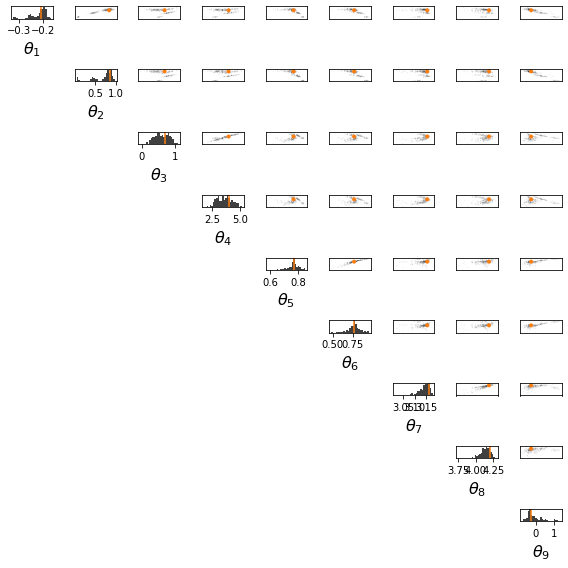

In [87]:
test_()

# Trying to understand

In [88]:
def test_():

    num_simulations = 250
    true_parameters = np.log([0.01, 0.5, 1.0, 0.01])

    parameters, observations = sim_data(
        gen_params=lambda num_simulations, rng: np.tile(
            true_parameters, num_simulations
        ).reshape(-1, 4),
        sim_model=lambda parameters, rng: Stats().calc(
            Model().sim(parameters, rng=rng)
        ),
        n_samples=num_simulations,
    )
    print(parameters.shape, observations.shape)
    # utils.plot_hist_marginals(parameters, ground_truth=np.log([0.01, 0.5, 1.0, 0.01]))
    plot_hist_marginals(
        observations, show_xticks=True, ground_truth=get_ground_truth_observation()
    )
    plt.show()

In [89]:
num_simulations = 250

In [90]:
true_parameters = np.log([0.01, 0.5, 1.0, 0.01])

In [ ]:
parameters, observations = sim_data(
    gen_params=lambda num_simulations, rng: np.tile(true_parameters, num_simulations).reshape(-1, 4),
    sim_model=lambda parameters, rng: Stats().calc(Model().sim(parameters, rng=rng)),
    n_samples=num_simulations,
)

In [1]:
a = None

In [2]:
[x is not None for x in a]

TypeError: 'NoneType' object is not iterable